In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA

from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn.model_selection import cross_val_score


%matplotlib inline
sns.set_style('white')

In [2]:
# load data
df = pd.read_csv('HR_comma_sep.csv')
df = df.dropna()
# rename some of the columns for easier reading
df = df.rename(columns={"sales": "department", "average_montly_hours": "average_monthly_hours","Work_accident": "work_accident"})

# create dummy features for categorical values in department and salary
df=pd.get_dummies(df)
trainsize = int(df.shape[0] / 2)

# split dataset into test and train
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# split dataset into features and target
Y_test = df_test['left'].values.reshape(-1,1)
Y_train = df_train['left'].values.reshape(-1,1)

# names = X.columns
# X = pd.DataFrame(preprocessing.scale(X), columns=names)
# X_test = X.iloc[trainsize:, :].copy()
X_test = df_test.loc[:, ~(df_test.columns).isin(['left'])]
X_train = df_train.loc[:, ~(df_test.columns).isin(['left'])]

# normalize the feature dataset

names_test = X_test.columns
names_train = X_test.columns

X_test = pd.DataFrame(preprocessing.scale(X_test), columns=names_test)
X_train = pd.DataFrame(preprocessing.scale(X_train), columns=names_train)

df.shape



(14999, 21)

### Run Logistic Regression without Penalties using Statsmodels

In [12]:
# Declare predictors.
X_train_statsmod = X_train
X_test_statsmod = X_test

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_train_statsmod['intercept'] = 1 
X_test_statsmod['intercept'] = 1 


#Target variable: df_train['left'] which is a binary output of whether person left the company
# Declare and fit the model.
logit = sm.Logit(df_train['left'], X_train_statsmod)
result = logit.fit()
# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
#print(result.summary())








Optimization terminated successfully.
         Current function value: 0.425582
         Iterations 30


In [13]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_train_statsmod)
# Code leaving as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df_train['left'], pred_y_statsmod)

print('\n Accuracy by left company status for training data')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

# try the test data
pred_statsmod_test = result.predict(X_test_statsmod)
# Code leaving as 1 if probability is greater than .5.
pred_y_statsmod_test = np.where(pred_statsmod_test < .5, 0, 1)

# Accuracy table.
table_2 = pd.crosstab(df_test['left'], pred_y_statsmod_test)


print('\n Accuracy by left company status for test data')
print(table_2)
print('\n Percentage accuracy')
print((table_2.iloc[0,0] + table_2.iloc[1,1]) / (table_2.sum().sum()))





 Accuracy by left company status for training data
col_0     0    1
left            
0      4957  542
1      1067  933

 Percentage accuracy
0.785438058408

 Accuracy by left company status for test data
col_0     0    1
left            
0      5188  741
1       847  724

 Percentage accuracy
0.788266666667


In [14]:
# Calculate accuracy. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_train_statsmod)
# Code leaving as 1 if probability is greater than .5.
threshold = .4
pred_y_statsmod = np.where(pred_statsmod < threshold, 0, 1)

# Accuracy table.
table = pd.crosstab(df_train['left'], pred_y_statsmod)

print('\n Accuracy by left company status for training data')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))

# try the test data
pred_statsmod_test = result.predict(X_test_statsmod)
# Code leaving as 1 if probability is greater than .4.
pred_y_statsmod_test = np.where(pred_statsmod_test < threshold, 0, 1)

# Accuracy table.
table_2 = pd.crosstab(df_test['left'], pred_y_statsmod_test)


print('\n Accuracy by left company status for test data')
print(table_2)
print('\n Percentage accuracy')
print((table_2.iloc[0,0] + table_2.iloc[1,1]) / (table_2.sum().sum()))




 Accuracy by left company status for training data
col_0     0     1
left             
0      4770   729
1       626  1374

 Percentage accuracy
0.819309241232

 Accuracy by left company status for test data
col_0     0    1
left            
0      4931  998
1       596  975

 Percentage accuracy
0.787466666667


### Initial results with Vanilla logistic regression using statsmodels
1. using statsmodels I was able to decrease the probability threshold for leaving the company to .4 and reduce the type I error resulting in a higher r2 on the test data but the improved performance didn't hold up for the test data
2. The R2 value is good - but it's possible that the data results aren't well represented - much more people stayed than left and the model only correctly identifies people who left 62% of the time

In [15]:
# Declare a logistic regression classifier.

lr = LogisticRegression(penalty = 'l2',C=1e9)
lr_lasso = LogisticRegression(penalty = 'l1',C=1e9)


# Fit the model.
fit = lr.fit(X_train, Y_train)
fit_lasso = lr_lasso.fit(X_train, Y_train)

# Display.
print('R2 Scores for train and test data L2 penalization')
print(lr.score(X_train, Y_train))
print(lr.score(X_test, Y_test))

print('R2 Scores for train and test data L1 penalization')
print(lr_lasso.score(X_train, Y_train))
print(lr_lasso.score(X_test, Y_test))



R2 Scores for train and test data L2 penalization
0.785438058408
0.788266666667
R2 Scores for train and test data L1 penalization
0.785438058408
0.788133333333


C:\Users\stace\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# Accuracy table.

pred_y_sklearn = lr.predict(X_train)
pred_y_sklearn_test = lr.predict(X_test)

table_lr = pd.crosstab(df_train['left'], pred_y_sklearn)

print('\n Accuracy by left company status for test data')
print(table_lr)
print('\n Percentage accuracy')
print((table_lr.iloc[0,0] + table_lr.iloc[1,1]) / (table_lr.sum().sum()))



 Accuracy by left company status for test data
col_0     0    1
left            
0      4957  542
1      1067  933

 Percentage accuracy
0.785438058408


### Results of applying a L1 and L2 regularization penalty to Logistic Regression
1. The results were fairly consistent with the result without penalty suggesting that the parameters were already small and did not need to be regularized
2. The model appears to perform equally well for the training and test data

### results of Lasso and Ridge regression using the penalty parameter in the sklearn logistic regression
1. The r2 values are fairly equivalent between the test and train data from the statsmodel regression - am I doing something wrong?

In [16]:
lass = linear_model.Lasso(alpha=.001)
lass.fit(X_train, Y_train)

print(lass.score(X_train, Y_train))

0.269124307449


### Results using the Lasso and Ridge regression methods in SKlearn
1. These models performed poorly - it's possible that because the data doesn't need regularization that they do perform well
2. It's unclear why the logistic regression with a L1 and L2 penalization performs better

In [20]:
# create an array of r2 values for both lasso and ridge regression
lambda_list = np.arange(.001,.2,.01)
r2_lasso_values = []
r2_ridge_values = []

for alpha in lambda_list:
    lass = linear_model.Lasso(alpha=alpha)
    lass.fit(X_train, Y_train)
    lasscore = lass.score(X_train, Y_train)
    r2_lasso_values.append(lasscore)

for alpha_ridge in lambda_list:
    ridgeregr = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=False) 
    ridgeregr.fit(X_train, Y_train)
    ridgescore = ridgeregr.score(X_train, Y_train)
    r2_ridge_values.append(ridgescore)
    


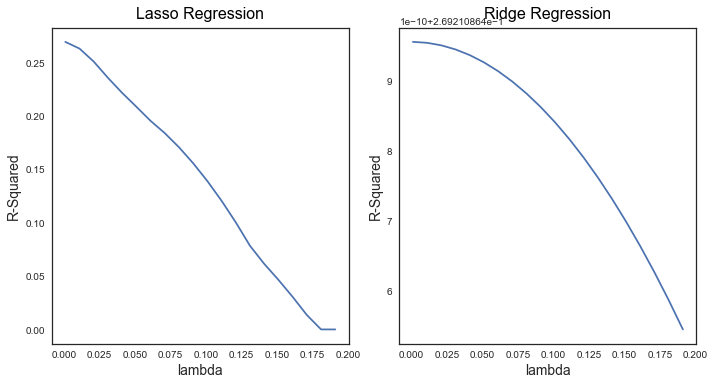

In [21]:
#Create a plot below of how  R2  varies across different values of  λ  for ridge and lasso regression. 
#Use logic and code similar to the ridge regression demonstration above, 
#and base your plot on the X_train2 feature set.

plt.figure(figsize=(10,10))
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'14'}

plt.subplot(2,2,1)
plt.plot(lambda_list, r2_lasso_values)
plt.xlabel('lambda', **axis_font)
plt.ylabel('R-Squared', **axis_font)
plt.title('Lasso Regression', **title_font)

plt.subplot(2,2,2)
plt.plot(lambda_list, r2_ridge_values)
plt.xlabel('lambda',  **axis_font)
plt.ylabel('R-Squared',  **axis_font)
plt.title('Ridge Regression', **title_font)
#plt.ylim((.5725,.5750))

plt.tight_layout()
plt.show()

In [31]:
# trying pca on the features for both lr model 

sklearn_pca = PCA(n_components=6)
Y_sklearn = sklearn_pca.fit_transform(X_train)
Y_sklearn_test = sklearn_pca.fit_transform(X_test)
#print(Y_sklearn)

cross_val_score(lr, Y_sklearn, df_train['left'], cv=10)
cross_val_score(lr, Y_sklearn_test, df_test['left'], cv=10)



array([ 0.80559254,  0.804     ,  0.80133333,  0.80266667,  0.792     ,
        0.812     ,  0.80266667,  0.79866667,  0.80666667,  0.8024032 ])

#### Conclusions:
1. The data does not appear to need regularization to produce an accurate model. Performing PCA and generating a new feature set of 6 components appears to result in the consistently highest accuracy